# Model selection - Example

## Example model
With the true model measurement data are simulated. In the comprehensive model an unneccessary model outflow is added. So, in model selection the true model should be preferred. 

![](model_selection_network.jpeg)


# Model Space Specifications File

The model selection specification file can be written in the following compressed format.

| modelId | YAML                             | $k1$ | $k2$ | $k3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;-  | 0;-  | 0;-  |

Alternatively, models can be explicitly specified. The below table is equivalent to the above table.

| modelId | YAML                             | $k1$ | $k2$ | $k3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1_0	| example_modelSelection.yaml	| 0	  | 0   |	0 | 
| M1_1	| example_modelSelection.yaml	| 0	  | 0	| - |
| M1_2	| example_modelSelection.yaml	| 0	  | - |	0 |
| M1_3	| example_modelSelection.yaml	| - |	0	| 0 |
| M1_4	| example_modelSelection.yaml	| 0	  | - |	- |
| M1_5	| example_modelSelection.yaml	| - |	0   |	- |
| M1_6	| example_modelSelection.yaml	| - |	- |	0 |
| M1_7	| example_modelSelection.yaml	| - |	- |	- |

Either of the above tables (as [.tsv](https://en.wikipedia.org/wiki/Tab-separated_values) files) are valid inputs. Any combinations of cells in the compressed or explicit format is also acceptable, including the following example.

| modelId | YAML                             | $k1$ | $k2$ | $k3$ |
|:---------|:----------------------------------|:----|:----|:----|
| M1      | example_modelSelection.yaml | 0;-  | 0;-  | 0  |
| M2      | example_modelSelection.yaml | 0;-  | 0;-  | -  |

Due to the topology of the example model, setting $k1$ to zero can result in a model with no dynamics. Hence, for this example, some parameters are set to non-zero fixed values. These parameters are not considered as estimated values in criterion (e.g. AIC) calculations.

Internally, estimated parameters (`-`) are represented by `float('nan')`.

In [1]:
model_spec_file = './model_selection/modelSelectionSpecification_example_modelSelection.tsv'
from pypesto.model_selection import unpack_file
f = unpack_file(model_spec_file)
f.seek(0)
print(f.read())

modelId	YAML	k1	k2	k3
M1_0_0	example_modelSelection.yaml	0	0	0
M1_1_0	example_modelSelection.yaml	0.2	0.1	nan
M1_2_0	example_modelSelection.yaml	0.2	nan	0
M1_3_0	example_modelSelection.yaml	nan	0.1	0
M1_4_0	example_modelSelection.yaml	0.2	nan	nan
M1_5_0	example_modelSelection.yaml	nan	0.1	nan
M1_6_0	example_modelSelection.yaml	nan	nan	0
M1_7_0	example_modelSelection.yaml	nan	nan	nan



# Forward Selection, Multiple Searches
Here, we show a typical workflow for model selection. First, a [PEtab](https://github.com/petab-dev/petab) problem is created. This is used to initialise a `ModelSelector`, along with a model specifications file.

In [2]:
petab_YAML = './model_selection/example_modelSelection.yaml'
import pypesto
import petab
petab_problem = petab.Problem.from_yaml(petab_YAML)
selector = pypesto.ModelSelector(petab_problem, model_spec_file)

Models can be selected with a model selection algorithm ([forward](https://en.wikipedia.org/wiki/Stepwise_regression)) and a comparison criterion ([AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)).

In [3]:
from pprint import pprint
selected_models, _, selection_history = selector.select('forward', 'AIC')
pprint(selected_models)
print('\n\nSelection history\n-----------------')
pprint(selection_history)

[{'AIC': 42.97523003111246,
  'BIC': 42.14226790802468,
  'MLE': [('k1', 0.0),
          ('k2', 0.0),
          ('k3', 0.0),
          ('sigma_x2', 4.462298367629622)],
  'compared_modelId': 'PYPESTO_INITIAL_MODEL',
  'modelId': 'M1_0_0',
  'row': {'YAML': 'example_modelSelection.yaml',
          'k1': 0.0,
          'k2': 0.0,
          'k3': 0.0,
          'modelId': 'M1_0_0'}},
 {'AIC': -6.175406081123061,
  'BIC': -6.383646611895006,
  'MLE': [('k1', 0.2),
          ('k2', 0.1),
          ('k3', -5.551115123125783e-17),
          ('sigma_x2', 0.12242920104294609)],
  'compared_modelId': 'M1_0_0',
  'modelId': 'M1_1_0',
  'row': {'YAML': 'example_modelSelection.yaml',
          'k1': 0.2,
          'k2': 0.1,
          'k3': nan,
          'modelId': 'M1_1_0'}}]


Selection history
-----------------
{'M1_0_0': {'AIC': 42.97523003111246,
            'BIC': 42.14226790802468,
            'MLE': [('k1', 0.0),
                    ('k2', 0.0),
                    ('k3', 0.0),
           

Plotting routines are available, to visualise the best model at each iteration of the selection process.

[]

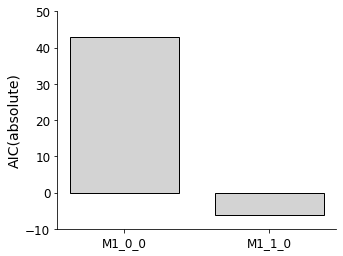

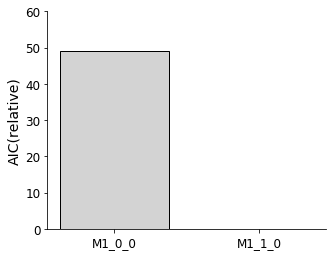

In [4]:
import pypesto.visualize.model_selection as visu
ax = visu.plot_selected_models(selected_models, criterion='AIC', relative=False)
ax = visu.plot_selected_models(selected_models, criterion='AIC')
ax.plot()

The result here is that a model with all parameters set to zero produces a lower AIC value than any model with exactly one estimated parameter (note: there may be additional (estimated) parameters that are specified in the PEtab parameters file; these would be estimated in all models).

To search more of the model space, the algorithm can be repeated. As models with 1 or less estimated parameters have already been optimized, subsequent `select` calls will begin with the next simplest model (in this case, models with exactly 2 estimated parameters), and move on to more complex models while each iteration improves the criterion.

In [5]:
selected_models, local_selection_history, selection_history = selector.select('forward', 'AIC')
pprint(selected_models)
print('\n\nSelection history\n-----------------')
pprint(selection_history)

[{'AIC': -4.14782967210447,
  'BIC': -4.772551264420304,
  'MLE': [('k1', 0.20924722664368026),
          ('k2', 0.08590702727463806),
          ('k3', 0.0),
          ('sigma_x2', 0.10387172361232846)],
  'compared_modelId': 'PYPESTO_INITIAL_MODEL',
  'modelId': 'M1_6_0',
  'row': {'YAML': 'example_modelSelection.yaml',
          'k1': nan,
          'k2': nan,
          'k3': 0.0,
          'modelId': 'M1_6_0'}},
 {'AIC': -6.056470701974835,
  'BIC': -6.681192294290669,
  'MLE': [('k1', 0.6225428502013322),
          ('k2', 0.02020087716639386),
          ('k3', 0.0010854020220811933),
          ('sigma_x2', 0.08859508825433743)],
  'compared_modelId': 'M1_6_0',
  'modelId': 'M1_7_0',
  'row': {'YAML': 'example_modelSelection.yaml',
          'k1': nan,
          'k2': nan,
          'k3': nan,
          'modelId': 'M1_7_0'}}]


Selection history
-----------------
{'M1_0_0': {'AIC': 42.97523003111246,
            'BIC': 42.14226790802468,
            'MLE': [('k1', 0.0),
            

[]

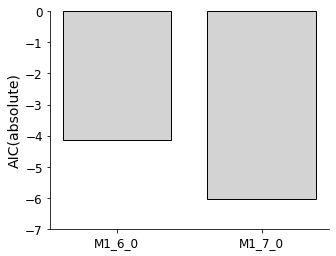

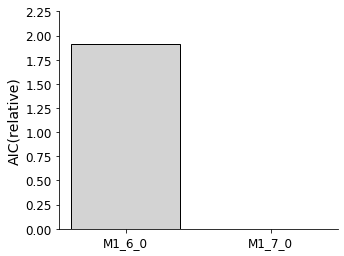

In [6]:
ax = visu.plot_selected_models(selected_models, criterion='AIC', relative=False)
ax = visu.plot_selected_models(selected_models, criterion='AIC')
ax.plot()

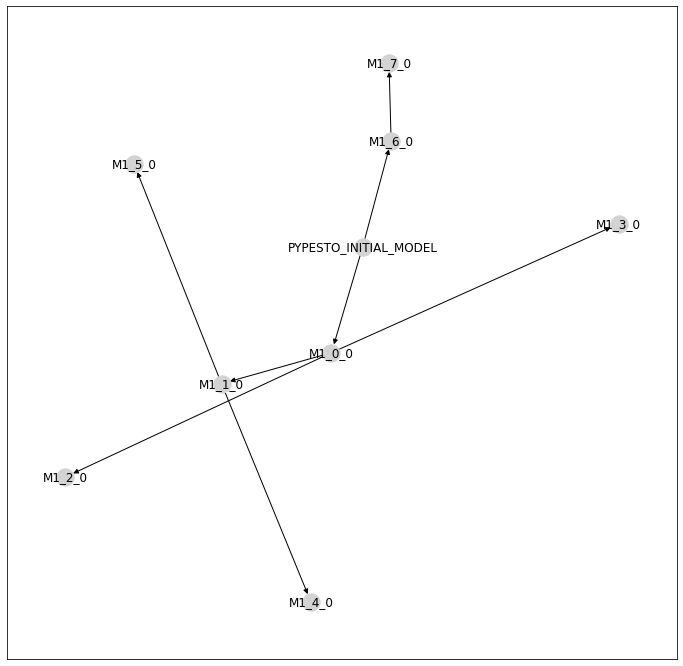

In [7]:
visu.plot_history_digraph(selection_history)

# Backward Selection, Custom Initial Model
Backward selection is specified by changing the algorithm from `'forward'` to `'backward'`in the `ModelSelector.select()`.

A custom initial model is specified with the optional `initial_model` argument of `ModelSelector.select()`. If no initial model is specified, then a virtual model is used for the purpose of finding the next valid models. For example, in forward selection, the initial virtual model with all parameters set to zero is used to find the next models to be tested. For backward selection, the initial virtual model has all parameters set to be estimated.

In [8]:
selector2 = pypesto.ModelSelector(petab_problem, model_spec_file)
initial_model = dict(zip(selector2.header, ['my_model', 'not_implemented.xml', float(0.1), float('nan'), float('nan')]))
print(f'Model specifications file column headers: {selector2.header}')
print('Initial model:')
pprint(initial_model)

Model specifications file column headers: ['modelId', 'YAML', 'k1', 'k2', 'k3']
Initial model:
{'YAML': 'not_implemented.xml',
 'k1': 0.1,
 'k2': nan,
 'k3': nan,
 'modelId': 'my_model'}


In [9]:
selected_models, local_selection_history, selection_history = selector2.select('backward',
                                                                               'AIC',
                                                                               initial_model=initial_model)
pprint(selected_models)
print('\n\nSelection history\n-----------------')
pprint(selection_history)

[{'AIC': 31.78450026210938,
  'BIC': 30.9515381390216,
  'MLE': [('k1', 0.1),
          ('k2', 1000.0),
          ('k3', 0.0),
          ('sigma_x2', 1.7561135493422317)],
  'compared_modelId': 'PYPESTO_INITIAL_MODEL',
  'modelId': 'my_model',
  'row': {'YAML': 'not_implemented.xml',
          'k1': 0.1,
          'k2': nan,
          'k3': nan,
          'modelId': 'my_model'}},
 {'AIC': -4.274513398103508,
  'BIC': -4.690994459647398,
  'MLE': [('k1', 0.2),
          ('k2', 0.10147816889261603),
          ('k3', 0.0),
          ('sigma_x2', 0.12142221944743797)],
  'compared_modelId': 'my_model',
  'modelId': 'M1_2_0',
  'row': {'YAML': 'example_modelSelection.yaml',
          'k1': 0.2,
          'k2': nan,
          'k3': 0.0,
          'modelId': 'M1_2_0'}}]


Selection history
-----------------
{'M1_0_0': {'AIC': 38.97523003111246,
            'BIC': 38.55874896956857,
            'MLE': [('k1', 0.0),
                    ('k2', 0.0),
                    ('k3', 0.0),
             

[]

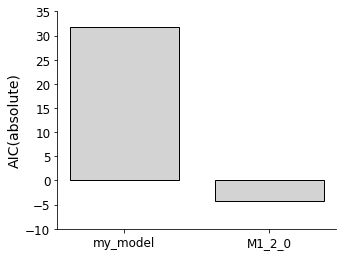

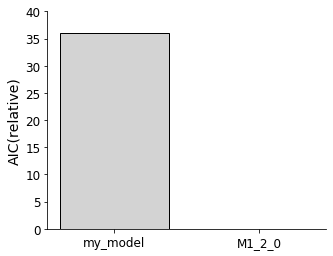

In [10]:
ax = visu.plot_selected_models(selected_models, criterion='AIC', relative=False)
ax = visu.plot_selected_models(selected_models, criterion='AIC')
ax.plot()

# Additional Options
There exist additional options that can be used to further customise selection algorithms.
## Select First Improvement
At each selection step, as soon as a model that improves on the previous model is encountered (by the specified criterion), it is selected and immediately used as the previous model in the next iteration of the selection. This is unlike the default behaviour, where all test models at each iteration are optimized, and the best of these is selected.
## Use Previous Maximum Likelihood Estimate As Startpoint
The maximum likelihood estimate parameters from the previous model is used as one of the startpoints in the multistart optimization of the test models. The default behaviour is that all startpoints are automatically generated by pyPESTO.
## Minimize Options
Optimization can be customised with a dictionary that specifies values for the corresponding keyword arguments of [minimize](https://github.com/ICB-DCM/pyPESTO/blob/master/pypesto/optimize/optimize.py).

In [11]:
selector3 = pypesto.ModelSelector(petab_problem, model_spec_file)

minimize_options = {
    'n_starts': 10
}

while True:
    try:
        _, _, selection_history = selector3.select('forward',
                                                   'AIC',
                                                   select_first_improvement=True,
                                                   startpoint_latest_mle=True,
                                                   minimize_options=minimize_options)
    except EOFError:
        break

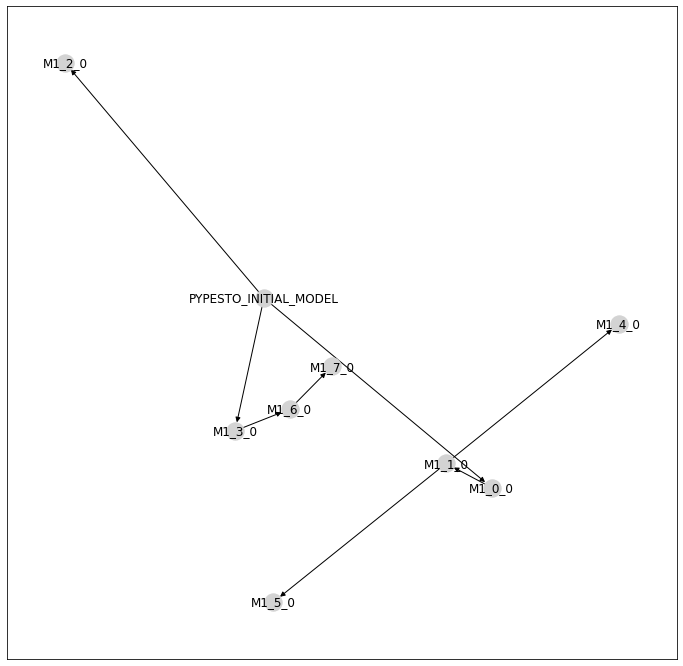

In [12]:
visu.plot_history_digraph(selection_history)